# Práctica 3

Ahora es tu turno de construir un modelo de segmentación semántica. 

## Ejercicio obligatorio (5 puntos)

El ejercicio obligatorio consiste en modificar el código del notebook para que no segmente únicamente la clase Grape sino que también segmente el resto de clases. Ten en cuenta que tendrás que usar una métrica equivalente a Dice y Jaccard para segmentación multiclase (por el momento solo está disponible la versión multiclase de Dice, [ver documentación de FastAI](https://docs.fast.ai/metrics.html#DiceMulti)). También notar que tendréis que utilizar un fichero de `codes` diferente (también disponible en la carpeta dataset).

## Ejercicios opcionales

A continuación se listan una serie de ejercicios adicionales. Para que estos ejercicios sean tenidos en cuenta han de ser documentadas en el propio notebook, dando una explicación de lo que se está haciendo. 

Es posible utilizar la funcionalidad de FastAI que vimos para clasificadores de imágenes, los primeros ejercicios opcionales son los siguientes:
- *Busqueda learning rate* (0.5 puntos). Busca el learning rate más adecuado para entrenar tu modelo con el *learning rate finder*.
- *Callbacks* (0.5 puntos). Es posible utilizar los callbacks de FastAI que vimos para clasificación de imágenes. Utiliza dichos callbacks para aplicar *early stopping* y guardar el mejor modelo que se encuentre durante el proceso de entrenamiento. 
- *Unfreeze* (0.5 puntos). En la práctica hemos entrenado la red estando esta congelada. Una vez que hayas entrenado la red usando el método descrito en las instrucciones, descongélala y continúa entrenadola por unas cuántas épocas adicionales. 

- *Mejoras de U-net* (1 punto). En el curso [Walk with fastAI](https://walkwithfastai.com/Segmentation) se explican una serie de mejoras que se pueden introducir para entrenar un modelo de segmentación usando U-net. Incluye dichas mejoras en tu modelo. 

- *Otros modelos* (0.75 puntos). La librería [SemTorch](https://github.com/WaterKnight1998/SemTorch) puede verse como el equivalente de IceVision para segmentación semántica. Esta librería proporciona distintos modelos de segmentación como DeepLab o HRNet. Entrena alguno de los modelos que proporciona dicha librería.  

- *Space en HuggingFace* (0.75 puntos). Crea en Huggingface un espacio para tu modelo. 

- *Dataset propio* (1 punto). Busca un dataset de segmentación ([enlace1](https://datasetsearch.research.google.com/search?query=semantic%20segmentation&docid=TDjpmVU%2FiGwWH123AAAAAA%3D%3D), [enlace2](http://yacvid.hayko.at/index.php?filter=+segmentation)) y crea un modelo para dicho dataset.

Incluye a continuación tu código. Al finalizar, recuerda guardar los cambios en GitHub utilizando la opción Archivo -> Guardar una copia en GitHub.

## Librerías

Comenzamos actualizando la librería FastAI. Al finalizar la instalación deberás reiniciar el kernel (menú Entorno de ejecución -> Reiniciar Entorno de ejecución).

In [1]:
!pip install fastai -Uq

Cargamos a continuación las librerías que necesitaremos en esta práctica.

In [1]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *


from pathlib import Path
import random

## Dataset

Para esta práctica vamos a usar como dataset el proporcionado en el trabajo [Deep neural networks for grape bunch segmentation in natural images from a consumer‑grade camera](https://link.springer.com/article/10.1007/s11119-020-09736-0). Este dataset dedicado a la segmentación de racimos de uva consta de 66 imágenes de entrenamiento y 14 de test con 5 categorías: background, leaves, wood, pole, y grape. Los siguientes comandos descargan y descomprimen dicho dataset. En este notebook vamos a usar solo dos clases: background y grape. 

In [1]:
%%capture
!wget https://www.dropbox.com/s/uknzc914w311web/dataset.zip?dl=1 -O dataset.zip
!unzip dataset.zip

Vamos a explorar el contenido de este dataset. Para ello vamos a crear un objeto Path que apunta al directorio que acabamos de crear. 

In [2]:
path=Path('dataset/')

Como en la práctica anterior, podemos ver el contenido de este directorio usando el comando `ls()`.

In [3]:
path.ls()

(#4) [Path('dataset/codes.txt'),Path('dataset/Images'),Path('dataset/codesAll.txt'),Path('dataset/Labels')]

Si exploráis el directorio podréis ver que hay dos carpetas llamadas Images y Labels. La carpeta Images contiene las imágenes del dataset, y la carpeta Labels contiene las en forma de máscara. Para cada imagen, hay un fichero de anotación siguiendo la siguiente nomenclatura: si la imagen se llama color_xxx.jpg, su fichero de anotación es gt_xxx.png. El dataset está partido en entrenamiento y test como puede verse en las carpetas Images y Labels. Además, se proporcionan dos ficheros txt que van a contener las clases de los objetos que utilizaremos en esta práctica. El fichero codes.txt contiene solo dos clases (background y grape), mientras que el fichero codesAll.txt contiene todas las posibles clases.  

In [4]:
(path/'Images').ls()

(#2) [Path('dataset/Images/train'),Path('dataset/Images/test')]

In [5]:
(path/'Images/train').ls()

(#66) [Path('dataset/Images/train/color_220.jpg'),Path('dataset/Images/train/color_63.jpg'),Path('dataset/Images/train/color_39.jpg'),Path('dataset/Images/train/color_207.jpg'),Path('dataset/Images/train/color_158.jpg'),Path('dataset/Images/train/color_74.jpg'),Path('dataset/Images/train/color_70.jpg'),Path('dataset/Images/train/color_44.jpg'),Path('dataset/Images/train/color_41.jpg'),Path('dataset/Images/train/color_50.jpg')...]

In [6]:

(path/'Labels/train').ls()

(#71) [Path('dataset/Labels/train/gt_58.png'),Path('dataset/Labels/train/gt_53.png'),Path('dataset/Labels/train/gt_46.png'),Path('dataset/Labels/train/gt_41.png'),Path('dataset/Labels/train/gt_71.png'),Path('dataset/Labels/train/gt_42.png'),Path('dataset/Labels/train/gt_164.png'),Path('dataset/Labels/train/gt_82.png'),Path('dataset/Labels/train/gt_76.png'),Path('dataset/Labels/train/gt_208.png')...]

## Definiciones previas

El proceso para entrenar nuestro modelo va a ser similar al visto en la práctica 1 para crear un modelo de clasificación. Sin embargo, para cargar nuestro dataset será necesario dar unas definiciones previas. Estas definiciones son necesarias para ajustar la carga del datos a la estructura de nuestro dataset. 

En primer lugar vamos a definir los paths donde se van a encontrar nuestras imágenes y sus etiquetas.

In [7]:
path_images = path/"Images"
path_labels = path/"Labels"

A continuación definimos el nombre que va a tener nuestra carpeta de test. 

In [8]:
test_name = "test"

Seguidamente definimos una función que dado el path de una imagen nos devuelve el path de su anotación.

In [9]:
def get_y_fn (x):
    return Path(str(x).replace("Images","Labels").replace("color","gt").replace(".jpg",".png"))

Seguidamente cargamos las clases que pueden tener los píxeles de nuestra imágenes y lo almacenamos en una lista `codes`.

In [10]:
codes = np.loadtxt(path/'codesAll.txt', dtype=str)

In [11]:
codes

array(['Background', 'Leaves', 'Wood', 'Pole', 'Grape'], dtype='<U10')

Podemos ahora ver alguna de las imágenes de nuestro dataset. 

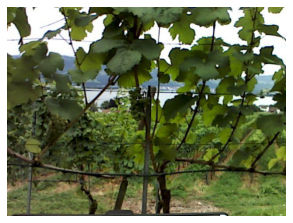

In [12]:
img_f = path_images/'train/color_206.jpg'
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

Y también la anotación asociada.

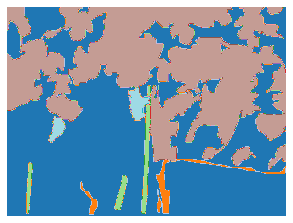

In [13]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

Como podemos ver en la imagen anterior tenemos una máscara donde cada tipo de objeto de nuestra imagen tiene un color distinto. 

## Partición del dataset

Como en cualquier problema de machine learning debemos partir nuestro dataset en entrenamiento y test. En nuestro caso los datos ya están separados por lo que vamos a definir una función que nos permite diferenciarlos gracias a la estructura de carpetas que usamos. 

In [14]:
def ParentSplitter(x):
    return Path(x).parent.name==test_name

## Data augmentation

Al igual que con los modelos definidos en prácticas anteriores podemos usar técnicas de aumento de datos, para lo que usaremos la librería Albumentations. Recordar que dichas transformaciones no deben aplicarse solo a la imagen sino también a su anotación. Para ello vamos a definir una clase que hereda de la clase `ItemTransform` y que nos va a permitir realizar transformaciones sobre pares (imagen,máscara). 

La clase `ItemTransform` tiene un método `encodes` que es el encargado de realizar la transformación sobre su entrada `x` que en este caso será un par (imagen,máscara). Además el constructor de la clase que vamos a definir recibirá como parámetro las transformaciones a aplicar. 

In [15]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    HorizontalFlip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    
    def __init__(self, aug): 
        self.aug = aug
        
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

En nuestro caso vamos a utilizar solo flips horizontales, rotaciones, y una operación que aplica una pequeña distorsión a la imagen. Dichas transformaciones se aplicarán de manera secuencia y de manera aleatoria.

In [16]:
transforms=Compose([HorizontalFlip(p=0.5),
                    Rotate(p=0.40,limit=10),GridDistortion()
                    ],p=1)

Por último construimos un objeto de la clase definida anteriormente.    

In [17]:
transformPipeline=SegmentationAlbumentationsTransform(transforms)

También va a ser necesario realizar una transformación adicional sobre las máscaras. Las máscaras contienen píxeles con 7 valores distintos (255: grape, 150: leaves, 76: pole, 74: pole, 29: wood, 25: wood, 0: background). Como vamos a trabajar únicamente con las clases grape y background, los píxeles del resto de clases deberán estar a 0 (es decir los vamos a considerar como background). Además, los números de las clases deben ser 0,1,2,... Es por esto que es necesario cambiar todos los píxeles con valor 255 a valor 1. Para realizar estas transformaciones definimos la siguiente clase.

In [18]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        mask[mask==0]=0
        mask[mask==25]=2
        mask[mask==29]=2
        mask[mask==74]=3
        mask[mask==76]=3
        mask[mask==150]=1
        mask[mask==255]=4
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

## Dataloader

Ya estamos listos para definir nuestro `DataBlock` y seguidamente nuestro `DataLoader`. Nuestro `DataBlock` se define del siguiente modo.

In [19]:
trainDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train']),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=[Resize((480,640)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

Vamos a explicar cada una de las componentes anteriores:
- `blocks=(ImageBlock, MaskBlock(codes))`. En este caso tenemos que la entrada de nuestro modelo va a ser una imagen (representada mediante un `ImageBlock`) y su salida es una máscara (representado mediante `MaskBlock`) cuyos posibles valores son aquellos proporcionados por la lista de clases almacenada en la variable `codes`.
- `get_items=partial(get_image_files,folders=['train'])`. El parámetro `get_items` sirve para indicar cómo cargar los datos de nuestro dataset. Para esto vamos a usar la función `get_image_files` que devuelve los paths de las imágenes que se encuentran dentro de la carpeta `folders` (en nuestro caso la carpeta `train`). 
- `get_y=get_y_fn`. El parámetro `get_y` sirve para indicar cómo obtener la anotación asociada con una entrada (recordar que una entrada va a ser una imagen definida a partir de su path). Para esto tenemos la función `get_y_fn` definida anteriormente. 
- `splitter=RandomSplitter(valid_pct=0.2)`. Como siempre debemos partir nuestro dataset para tener un conjunto de validación de cara a seleccionar nuestros hiperparámetros. En este caso partimos el conjunto de entrenamiento usando un porcentaje 80/20.
- `item_tfms=[Resize((480,640)), TargetMaskConvertTransform(), transformPipeline]`. En el parámetro `item_tfms` indicamos las transformaciones que vamos a aplicar a nuestras imágenes y sus correspondientes máscaras. Además de las explicadas anteriormente vamos a reescalar las imágenes al tamaño 480x640.
- `batch_tfms=Normalize.from_stats(*imagenet_stats)`. En el parámetro `batch_tfms` indicamos las transformaciones que se realizan a nivel de batch. En este caso como en nuestro modelo utilizaremos un backbone preentrenado en ImageNet debemos normalizar las imágenes para que tengan la escala de esas imágenes. 

Con las explicaciones anteriores en sencillo comprender como definimos el siguiente `DataBlock` que nos servirá para evaluar nuestros modelos en el conjunto de test. 

In [20]:
testDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train','test']),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize((480,640)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

Ahora ya podemos definir nuestros `Dataloaders` indicando el path donde se encuentran las imágenes y el batch size que vamos a utilizar. 

In [21]:
bs = 4
trainDLS = trainDB.dataloaders(path_images,bs=bs)
testDLS = testDB.dataloaders(path_images,bs=bs)

Como siempre es conveniente mostrar un batch para comprobar que se están cargando los datos correctamente.

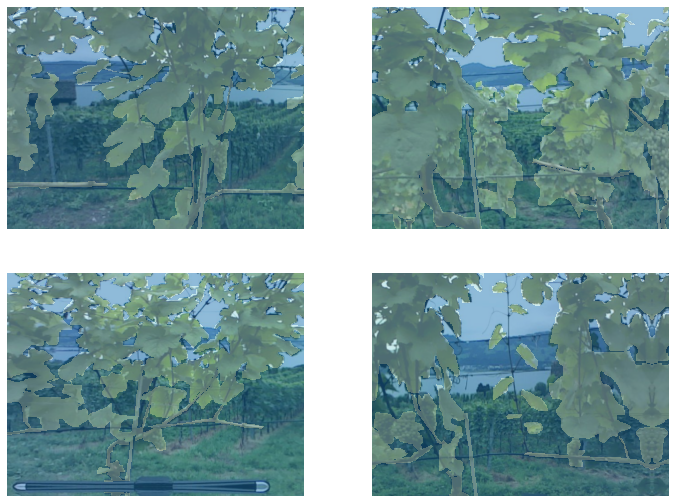

In [22]:
trainDLS.show_batch(vmin=0,vmax=1,figsize=(12, 9))

## Definición de modelo

Ya podemos definir nuestro modelo y entrenarlo como hemos hecho en prácticas anteriores. Para ello vamos a crear un `Learner` mediante la función `unet_learner` a la cual le tenemos que proporcionar el `DataLoader` el backbone que vamos a utilizar (en este caso usaremos un modelo Resnet-18) y las métricas [Dice](https://docs.fast.ai/metrics.html#Dice) y [Jaccard](https://docs.fast.ai/metrics.html#JaccardCoeff) que emplearemos para evaluar nuestro modelo. 

In [25]:
learn = unet_learner(trainDLS,resnet18,metrics=[DiceMulti()]).to_fp16()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Por último entrenamos nuestro modelo.

In [26]:
learn.fit_one_cycle(20,3e-3)

epoch,train_loss,valid_loss,dice_multi,time
0,1.056065,0.713986,0.298543,00:07
1,0.911083,0.531433,0.337927,00:07
2,0.750179,0.446576,0.356240,00:07
3,0.636618,0.366168,0.416130,00:06
4,0.559683,0.443105,0.579471,00:07
5,0.553982,0.427416,0.543263,00:07
6,0.507505,0.303049,0.614767,00:06
7,0.465356,0.298368,0.637552,00:06
8,0.425377,0.259450,0.740879,00:06
9,0.397339,0.277823,0.742434,00:06


Una vez entrenado el modelo lo vamos a guardar para usarlo posteriormente. Lo primero que hacemos es extraer el modelo del `Learner` y cargarlo en la CPU.

In [27]:
aux=learn.model
aux=aux.cpu()

Ahora vamos a guardarlo, para lo cual es necesario cargar una imagen que le servirá como referencia para realizar las transformaciones necesarias. Para ello es necesario normalizar la imagen para que sigan el estándar de ImageNet.

In [28]:
import torchvision.transforms as transforms
img = PILImage.create(path_images/'train/color_206.jpg')
transformer=transforms.Compose([transforms.Resize((480,640)),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                                    [0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])])
img=transformer(img).unsqueeze(0)
img=img.cpu()

traced_cell=torch.jit.trace(aux, (img))
traced_cell.save("unetPr1.pth")

/usr/local/lib/python3.8/dist-packages/fastai/vision/models/unet.py:39: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if ssh != up_out.shape[-2:]:
/usr/local/lib/python3.8/dist-packages/fastai/vision/models/unet.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.orig.shape[-2:] != x.shape[-2:]:


## Evaluando el modelo

Al igual que vimos para los modelos de clasificación, la métrica mostrada durante el proceso de entrenamiento se refiere al conjunto de validación, mientras que nos interesa saber el resultado obtenido para el conjunto de test.

Para ello debemos modificar el dataloader del objeto `Learn` que hemos entrenado anteriormente.

In [29]:
learn.dls = testDLS

Por último evaluamos nuestro modelo usando el método `validate()`. En este caso el método `validate()` devuelve tres valores, el valor de la pérdida, y el valor de las métricas definidas anteriormente con respecto al conjunto de test. 

In [30]:
learn.validate()

(#2) [0.46193450689315796,0.6818045077941294]

## Inferencia

Vamos a ver cómo usar el modelo ante una nueva imagen. Para ello lo primero que vamos a hacer es cargar el modelo. El modelo inicialmente lo cargaremos en la CPU, pero posteriormente si hay una GPU disponible la usaremos para inferencia.

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model = torch.jit.load("unetPr1.pth")
model = model.cpu()
model.eval()

RecursiveScriptModule(
  original_name=DynamicUnet
  (layers): RecursiveScriptModule(
    original_name=ModuleList
    (0): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Conv2d)
      (1): RecursiveScriptModule(original_name=BatchNorm2d)
      (2): RecursiveScriptModule(original_name=ReLU)
      (3): RecursiveScriptModule(original_name=MaxPool2d)
      (4): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(
          original_name=BasicBlock
          (conv1): RecursiveScriptModule(original_name=Conv2d)
          (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
          (relu): RecursiveScriptModule(original_name=ReLU)
          (conv2): RecursiveScriptModule(original_name=Conv2d)
          (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
        )
        (1): RecursiveScriptModule(
          original_name=BasicBlock
          (conv1): RecursiveScriptModule(original_name=Conv

El siguiente paso es cargar la imagen, para lo que usaremos la librería `PIL`.

In [32]:
import PIL

In [33]:
img = PIL.Image.open('dataset/Images/test/color_154.jpg')

La siguiente instrucción permite mostrar la imagen que acabamos de cargar. 

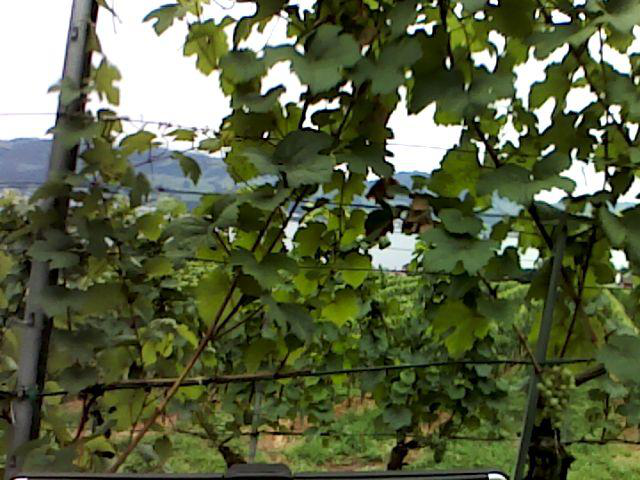

In [34]:
img

Ya estaríamos listos para relizar las predicciones sobre la imagen. Sin embargo, cabe recordar que primero debemos reescalar las imágenes y normalizarlas.

In [35]:
import torchvision.transforms as transforms
def transform_image(image):
    my_transforms = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])
    image_aux = image
    return my_transforms(image_aux).unsqueeze(0).to(device)

El siguiente paso consiste en transformar la imagen. 

In [36]:
image = transforms.Resize((480,640))(img)
tensor = transform_image(image=image)

Ahora ya podemos realizar pasarle el objeto construido anteriormente al modelo para realizar la predicción. 

In [37]:
model.to(device)
with torch.no_grad():
    outputs = model(tensor)

outputs = torch.argmax(outputs,1)

Ahora almacenamos el resultado en un array y convertimos el índice asociado con la clase grape (que era 1) al valor 255.

In [46]:
mask = np.array(outputs.cpu())
mask[mask==0]=0
mask[mask==1]=150
mask[mask==2]=25
mask[mask==3]=74
mask[mask==4]=255

La predicción devuelta por el modelo es un vector de tamaño 480x640 por lo que tendremos que ponerla en forma de matriz.

In [47]:
mask=np.reshape(mask,(480,640))

Con esto ya podemos mostrar la máscara generada. 

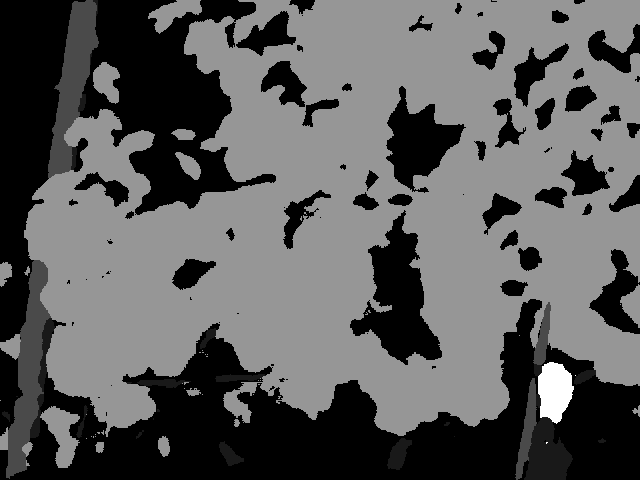

In [48]:
Image.fromarray(mask.astype('uint8'))

Podemos compararla con la máscara real.

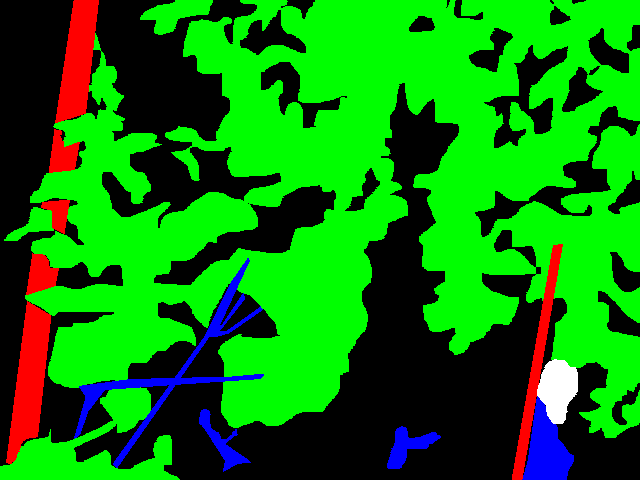

In [49]:
PIL.Image.open('dataset/Labels/test/gt_154.png')

Como vemos el modelo se aproxima bastante, pero la segmentación no es excesivamente buena. En la práctica veremos cómo crear mejores modelos. 